# Network data preprocessing

Data Format

| Col1 | Col2 | Col3   | Col4      |
|------|------|--------|-----------|
| src  | dest | weight | timestamp |

In [83]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

from string import Template
import json

In [16]:
# Read/parse data
data_loc = 'data/mammalia-raccoon-proximity.edges'

raw_data = []
with open(data_loc) as f:
    raw_data = [list(map(int, line.strip().split(' '))) for line in f.readlines()]

In [69]:
# Convert to numpy
data_arr = np.array(raw_data, dtype=float)

print(len(data_arr))
print(len(data_arr[0]))
print(data_arr[0])

1997
4
[ 1.  2. 30.  1.]


In [70]:
sample_arr = data_arr[(data_arr[:,3] < 5)]
print(len(sample_arr))
sample_arr

263


array([[  1.,   2.,  30.,   1.],
       [  1.,   3., 104.,   1.],
       [  1.,   4.,   2.,   1.],
       ...,
       [ 13.,  14., 134.,   4.],
       [ 13.,   4.,   4.,   4.],
       [  6.,   7.,   2.,   4.]])

In [71]:
src_nodes = np.unique(sample_arr[:,0])
dst_nodes = np.unique(sample_arr[:,1])

print('# src:', len(src_nodes))
print('# dest:', len(dst_nodes))

# src: 21
# dest: 21


In [72]:
# Check consistent nodes
np.setxor1d(src_nodes, dst_nodes)

array([ 1.,  4.,  5.,  7., 12., 23.])

In [73]:
max(sample_arr[:, 2]), min(sample_arr[:, 2])

(119759.0, 1.0)

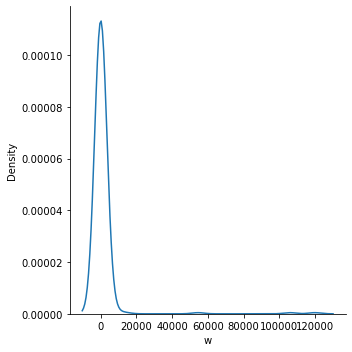

In [75]:
# Visualize weight distribution
sample_df = pd.DataFrame(sample_arr, columns=['src', 'dst', 'w', 'time'])

sns.displot(sample_df, x='w', kind='kde')

In [76]:
list(sample_df['w'].value_counts().sort_index(ascending=False).index)

[119759.0,
 105856.0,
 54558.0,
 13673.0,
 8202.0,
 7349.0,
 3889.0,
 3287.0,
 2136.0,
 1835.0,
 1412.0,
 1360.0,
 1201.0,
 754.0,
 675.0,
 630.0,
 575.0,
 561.0,
 548.0,
 532.0,
 508.0,
 469.0,
 446.0,
 378.0,
 329.0,
 282.0,
 270.0,
 264.0,
 261.0,
 233.0,
 211.0,
 195.0,
 191.0,
 180.0,
 174.0,
 165.0,
 162.0,
 161.0,
 160.0,
 149.0,
 145.0,
 137.0,
 136.0,
 134.0,
 119.0,
 115.0,
 114.0,
 104.0,
 100.0,
 99.0,
 98.0,
 92.0,
 89.0,
 83.0,
 68.0,
 65.0,
 63.0,
 54.0,
 52.0,
 49.0,
 48.0,
 47.0,
 46.0,
 45.0,
 43.0,
 41.0,
 39.0,
 38.0,
 37.0,
 34.0,
 33.0,
 31.0,
 30.0,
 29.0,
 27.0,
 26.0,
 25.0,
 24.0,
 23.0,
 22.0,
 21.0,
 20.0,
 19.0,
 18.0,
 17.0,
 16.0,
 15.0,
 14.0,
 13.0,
 12.0,
 11.0,
 10.0,
 9.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0]

In [86]:
# Build scaling pipelines (only scalers, no estimator)
scaler_pipe = Pipeline([('robust', RobustScaler()), ('min_max', MinMaxScaler())])

In [88]:
# Scale weights
sample_arr[:,2] = scaler_pipe.fit_transform(sample_arr[:,2].reshape(-1, 1)).ravel()
sample_arr[:10]

array([[1.00000000e+00, 2.00000000e+00, 2.42155013e-04, 1.00000000e+00],
       [1.00000000e+00, 3.00000000e+00, 8.60067803e-04, 1.00000000e+00],
       [1.00000000e+00, 4.00000000e+00, 8.35017285e-06, 1.00000000e+00],
       [5.00000000e+00, 6.00000000e+00, 1.36942835e-03, 1.00000000e+00],
       [5.00000000e+00, 7.00000000e+00, 8.26667112e-04, 1.00000000e+00],
       [5.00000000e+00, 8.00000000e+00, 5.25225872e-03, 1.00000000e+00],
       [5.00000000e+00, 9.00000000e+00, 2.17104494e-03, 1.00000000e+00],
       [5.00000000e+00, 2.00000000e+00, 3.17306568e-04, 1.00000000e+00],
       [5.00000000e+00, 1.00000000e+01, 2.73885669e-03, 1.00000000e+00],
       [5.00000000e+00, 1.10000000e+01, 9.51919705e-04, 1.00000000e+00]])

In [89]:
# Setup structure to output as JSON
output_dict = { 
    'nodes': [{'id': x} for x in np.unique(sample_arr[:, [0, 1]])], 
    'links': [{'source': a, 'target': b, 'value': c, 'timestamp': d} for (a, b, c, d) in sample_arr]
}

In [90]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


output_loc = 'data/node_links.json'
with open(output_loc, 'w') as f:
    json.dump(output_dict, f, cls=NpEncoder)

In [91]:
json.load(open(output_loc))

{'nodes': [{'id': 1.0},
  {'id': 2.0},
  {'id': 3.0},
  {'id': 4.0},
  {'id': 5.0},
  {'id': 6.0},
  {'id': 7.0},
  {'id': 8.0},
  {'id': 9.0},
  {'id': 10.0},
  {'id': 11.0},
  {'id': 12.0},
  {'id': 13.0},
  {'id': 14.0},
  {'id': 15.0},
  {'id': 16.0},
  {'id': 17.0},
  {'id': 18.0},
  {'id': 19.0},
  {'id': 20.0},
  {'id': 21.0},
  {'id': 22.0},
  {'id': 23.0},
  {'id': 24.0}],
 'links': [{'source': 1.0,
   'target': 2.0,
   'value': 0.00024215501260876101,
   'timestamp': 1.0},
  {'source': 1.0,
   'target': 3.0,
   'value': 0.0008600678034035304,
   'timestamp': 1.0},
  {'source': 1.0,
   'target': 4.0,
   'value': 8.35017284857798e-06,
   'timestamp': 1.0},
  {'source': 5.0,
   'target': 6.0,
   'value': 0.0013694283471667862,
   'timestamp': 1.0},
  {'source': 5.0,
   'target': 7.0,
   'value': 0.0008266671120092186,
   'timestamp': 1.0},
  {'source': 5.0,
   'target': 8.0,
   'value': 0.005252258721755541,
   'timestamp': 1.0},
  {'source': 5.0,
   'target': 9.0,
   'value': 0